## Test pytorch modeling before moving to scripts

In [16]:
import torch 
import torch.optim as optim
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
%matplotlib inline
import joblib
from scipy.sparse import csr_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [4]:
train_clean = joblib.load('../../data/train_clean.pckl')
test_clean = joblib.load('../../data/test_clean.pckl')
vectorizer = joblib.load('../vectorizer.pckl')
splits = joblib.load('../splits.pckl')

In [7]:
def get_loader(split):
    
    idx = [i for i, x in enumerate(splits) if x==0]
    
    # subset training data and target on idx_list
    X = train_clean.loc[idx, 'clean_text'].copy()
    y = train_clean.loc[idx, 'toxic'].copy()
    
    # transform to dense tfidf matrix
    X_bow = csr_matrix(vectorizer.transform(X), dtype=np.float32).todense()
    
    # create tensor dataset
    X_tensor = torch.from_numpy(X_bow)
    y_tensor = torch.LongTensor([int(x) for x in y])
    
    split_set = torch.utils.data.TensorDataset(X_tensor, y_tensor)

    # return dataloader
    return(torch.utils.data.DataLoader(split_set, batch_size=100, shuffle=False, num_workers=2))

In [55]:
w = train_clean['toxic'].value_counts(normalize=True).iloc[::-1]
C = Variable(torch.FloatTensor([w[1], w[0]])).cuda()

In [58]:
class BoWClassifier(nn.Module):  # inheriting from nn.Module!

    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear1 = nn.Linear(vocab_size, 64)
        self.dropout = nn.Dropout()
        self.linear2 = nn.Linear(64, num_labels)

    def forward(self, x):
        x = self.linear1(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return F.log_softmax(x, dim=1)

[0,     0] loss: 0.006828
[0,     1] loss: 0.006585
[0,     2] loss: 0.006393
[0,     3] loss: 0.006188
[0,     4] loss: 0.005974
[0,     5] loss: 0.005743
[0,     6] loss: 0.005522
[0,     7] loss: 0.005296
[0,     8] loss: 0.005074
[0,     9] loss: 0.004866
0  - Test AUC: 0.928058  %
[1,     0] loss: 0.004687
[1,     1] loss: 0.004515
[1,     2] loss: 0.004327
[1,     3] loss: 0.004197
[1,     4] loss: 0.004042
[1,     5] loss: 0.003920
[1,     6] loss: 0.003790
[1,     7] loss: 0.003681
[1,     8] loss: 0.003568
[1,     9] loss: 0.003470
1  - Test AUC: 0.963215  %
[2,     0] loss: 0.003348
[2,     1] loss: 0.003266
[2,     2] loss: 0.003181
[2,     3] loss: 0.003084
[2,     4] loss: 0.003032
[2,     5] loss: 0.002931
[2,     6] loss: 0.002874
[2,     7] loss: 0.002793
[2,     8] loss: 0.002735
[2,     9] loss: 0.002664
2  - Test AUC: 0.980748  %
[3,     0] loss: 0.002596
[3,     1] loss: 0.002554
[3,     2] loss: 0.002481
[3,     3] loss: 0.002428
[3,     4] loss: 0.002384
[3,     5

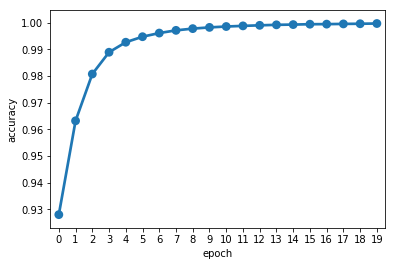

In [61]:
model = BoWClassifier(2, 177012)
model.cuda()

loss_function = nn.NLLLoss(weight=C)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=.001)

test_accuracy = []

for epoch in range(20):
    
    early_stopping_epochs = 2
    
    running_loss = 0.0
    running_obs = 0
    
    for s in range(10):

        loader = get_loader(s)

        for i, data in enumerate(loader, 0):

            inputs, labels = data
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            optimizer.zero_grad()
            
            log_probs = model(inputs)

            loss = loss_function(log_probs, labels)
            loss.backward()
            optimizer.step()
        
            running_loss += loss.data[0]
            running_obs += len(data[1])
        
        print('[%d, %5d] loss: %.6f' % (epoch, s, running_loss / running_obs))
        running_loss = 0.0
        running_obs = 0
        
    pred = []
    act = []
    
    for s in range(10, 15):

        loader = get_loader(s)
        
        for data in loader:
            inputs, labels = data
            outputs = model(Variable(inputs).cuda())
            pred += list(outputs[:,1].data)
            act += list(labels)

    fpr, tpr, thresholds = roc_curve(act, pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    roc_auc 

    if epoch% 1 == 0:
        print(epoch, ' - Test AUC: %0.6f  %%' % roc_auc)
    test_accuracy.append(roc_auc)
    
    try:
        m = test_accuracy.index(max(test_accuracy))
        t = len(test_accuracy)
        if (t-m) > early_stopping_epochs:
            print('Early Stopping ')
            break
    except:
        pass
    
df = pd.DataFrame(data = {'accuracy' :  test_accuracy, 
                          'epoch':  range(len(test_accuracy))})

sns.pointplot(x='epoch', y='accuracy', data=df)

In [62]:
type(model)

__main__.BoWClassifier

In [64]:
torch.save(model.state_dict(), 'model_savee_test')

In [65]:
model.load_state_dict(torch.load('model_savee_test'))

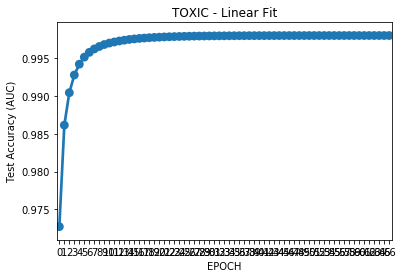

In [53]:
df = pd.DataFrame(data = {'accuracy' :  test_accuracy, 
                          'epoch':  range(len(test_accuracy))})

ax = sns.pointplot(x='epoch', y='accuracy', data=df)
ax.set(xlabel='EPOCH', ylabel='Test Accuracy (AUC)', title='TOXIC - Linear Fit')
plt.savefig('test_fig')

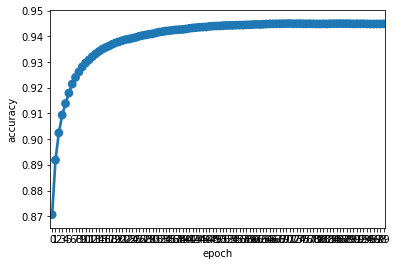

In [325]:

df = pd.DataFrame(data = {'accuracy' :  test_accuracy, 
                          'epoch':  range(len(test_accuracy))})

sns.pointplot(x='epoch', y='accuracy', data=df)

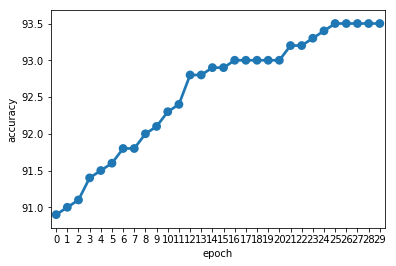

In [245]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(data = {'accuracy' :  test_accuracy, 
                          'epoch':  range(len(test_accuracy))})

sns.pointplot(x='epoch', y='accuracy', data=df)

In [287]:
from sklearn import metrics

In [283]:
labels


 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 0
 1
 1
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 1
 0
 0
 0
 0
 0
 0
 1
 1
 0
 1
 0
 0
 0
 0
[torch.LongTensor of size 100]

In [315]:
pred = []
act = []

for data in testloader:
    inputs, labels = data
    outputs = model(Variable(inputs).cuda())
    pred += list(outputs[:,1].data)
    act += list(labels)
    
fpr, tpr, thresholds = metrics.roc_curve(act, pred, pos_label=1)
roc_auc = metrics.auc(fpr, tpr)
roc_auc 

0.9407848386642244

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)